# Going to Jupiter with Python using Jupyter and poliastro

In [1]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

solar_system_ephemeris.set("jpl")

import numpy as np

from poliastro.bodies import Sun, Earth, Jupiter
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.maneuver import Maneuver
from poliastro.plotting import StaticOrbitPlotter
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range

All the data for Juno’s mission is sorted [here](https://github.com/poliastro/poliastro/wiki/EuroPython:-Per-Python-ad-Astra). The main maneuvers that the spacecraft will perform are listed down:
- Inner cruise phase 1: This will set Juno in a new orbit around the sun.
- Inner cruise phase 2: Fly-by around Earth. Gravity assist is performed.
- Inner cruise phase 3: Jupiter insertion maneuver.

Let us first define the main dates and other relevant parameters of the mission:

In [2]:
## Main dates
date_launch = Time("2011-08-05 16:25", scale="utc").tdb
date_flyby = Time("2013-10-09 19:21", scale="utc").tdb
date_arrival = Time("2016-07-05 03:18", scale="utc").tdb

# Atlas V supplied a launch energy
C_3 = 31.1 * u.km ** 2 / u.s ** 2

With previous dates we can create the different orbits that define the position of the Earth along the mission:

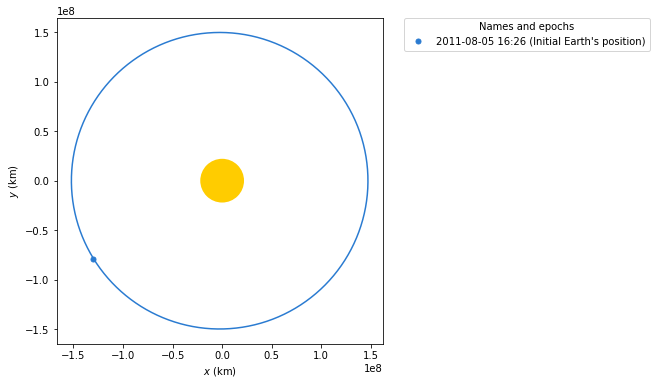

In [3]:
# Plot initial Earth's position
Earth.plot(date_launch, label="Initial Earth's position");

Since both Earth states have been obtained (initial and flyby) we can now solve for Juno’s maneuvers. The first one sets Juno into an elliptical orbit around the Sun so that it applies a gravity assist around the Earth:

In [4]:
earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival, periods=500))

r_e0, v_e0 = earth.rv(date_launch)

In [5]:
# Assume that the insertion velocity is tangential to that of the Earth
dv = C_3 ** 0.5 * v_e0 / norm(v_e0)

# We create the maneuver from impulse constructor
man = Maneuver.impulse(dv)

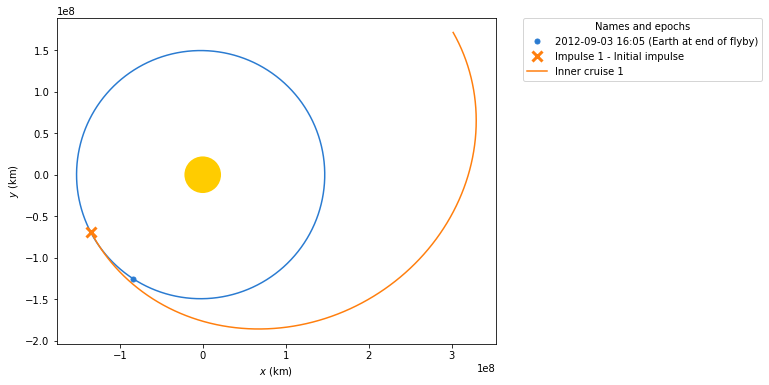

In [8]:
ss_e0 = Orbit.from_ephem(Sun, earth, date_launch)
ss_efly = Orbit.from_ephem(Sun, earth, date_flyby)

# Inner Cruise 1
ic1 = ss_e0.apply_maneuver(man)
ic1_end = ic1.propagate_to_anomaly(180.0 * u.deg)

# We can check new bodies positions
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(Earth, ic1_end.epoch, label="Earth at end of flyby")
plotter.plot_maneuver(ss_e0, man, color="C1", label="Initial impulse")
plotter.plot_trajectory(
    ic1.sample(max_anomaly=180 * u.deg),
    label="Inner cruise 1",
    color="C1",
);

We can check that the period of the orbit is similar to the one stated in the mission’s documentation. Remember that in the previous plot we only plotter half of the orbit for Juno’s first maneuver and the period is the time that would take Juno to complete one full revolution around this new orbit.

In [9]:
ic1.period.to(u.day)

<Quantity 785.85267377 d>

Notice that in the previous plot that Earth’s position is not the initial one since while Juno is moving Earth also does. We now solve for the Lambert maneuver in order to perform a flyby around the earth when it is at flyby date:

In [10]:
# Let's compute the Lambert solution to do the flyby of the Earth
man_flyby = Maneuver.lambert(ic1_end, ss_efly)
imp_a, imp_b = man_flyby.impulses

print("Initial impulse:", imp_a)
print("Final impulse:", imp_b)

Initial impulse: (<Quantity 0. s>, <Quantity [886.93797004, 568.13322972, 247.37221072] m / s>)
Final impulse: (<Quantity 34658187.19869172 s>, <Quantity [-10545.24842414,  -5813.72343976,  -2518.61652123] m / s>)


In [ ]:
# Check the initial delta-V
dv_a = imp_a[-1]
norm(dv_a.to(u.km / u.s))

We can now solve for the flyby orbit that will help Juno with the gravity assist. Again, the inner phase 2 maneuver is defined till Juno reaches Earth’s position for the flyby date although the full orbit is plotted:

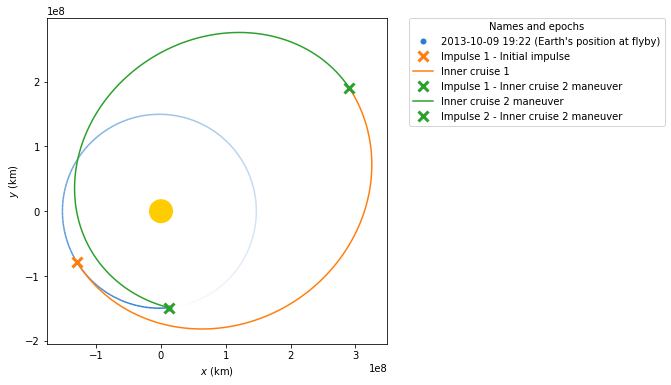

In [11]:
# Let us apply the maneuver
ic2, ss_flyby = ic1_end.apply_maneuver(man_flyby, intermediate=True)

# We propagate the transfer orbit till the flyby occurs
ic2_end = ic2.propagate(date_flyby)

plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(
    Earth,
    ss_efly.epoch,
    label="Earth's position at flyby",
    trail=True,
)
plotter.plot_maneuver(ss_e0, man, color="C1", label="Initial impulse")
plotter.plot_trajectory(
    ic1.sample(max_anomaly=180 * u.deg), label="Inner cruise 1", color="C1"
)
plotter.plot_maneuver(
    ic1_end,
    man_flyby,
    label="Inner cruise 2 maneuver",
    color="C2",
);

We can now start solving for the maneuver that will take Juno to Jupiter. Another Lambert maneuver is required but first let us solve for Jupiter position on arrival:

In [12]:
# And now, go to Jupiter!
jupiter = Ephem.from_body(Jupiter, time_range(date_launch, end=date_arrival))

ss_j = Orbit.from_ephem(Sun, jupiter, date_arrival)

In [14]:
# Solving for maneuver to Jupiter
man_jupiter = Maneuver.lambert(ic2_end, ss_j)
imp_a, imp_b = man_jupiter.impulses

print("Initial impulse:", imp_a)
print("Final impulse:", imp_b)

Initial impulse: (<Quantity 0. s>, <Quantity [-7721.07635581,  2075.30250271,  3695.17037263] m / s>)
Final impulse: (<Quantity 86342221.00159356 s>, <Quantity [   14.32045511, -5178.0801084 , -1696.54538318] m / s>)


In [15]:
# Apply the maneuver
ic3, ss_target = ic2_end.apply_maneuver(man_jupiter, intermediate=True)
ic3_end = ic3.propagate(date_arrival)

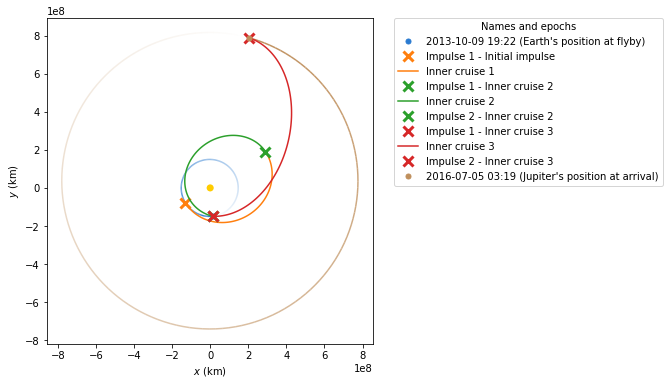

In [16]:
# Final plot for the whole mission
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(
    Earth,
    date_flyby,
    label="Earth's position at flyby",
    trail=True,
)
plotter.plot_maneuver(ss_e0, man, color="C1", label="Initial impulse")
plotter.plot_trajectory(
    ic1.sample(max_anomaly=180 * u.deg), label="Inner cruise 1", color="C1"
)
plotter.plot_maneuver(
    ic1_end,
    man_flyby,
    label="Inner cruise 2",
    color="C2",
)
plotter.plot_maneuver(
    ic2_end,
    man_jupiter,
    label="Inner cruise 3",
    color="C3",
)
plotter.plot_body_orbit(
    Jupiter, date_arrival, label="Jupiter's position at arrival", trail=True
);

---
***
---

###### Please ignore the cell below. It just loads our style for the notebooks.

In [7]:
from IPython.core.display import HTML
def css_styling(filepath):
    styles = open(filepath, 'r').read()
    return HTML(styles)
css_styling('../styles/custom.css')

---
***
---